In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from scipy import ndimage
from scipy import signal
from pylab import *
import time
import math
import random 

import pywt
import pywt.data

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import cv2

from mpl_toolkits.mplot3d import Axes3D

import os

from copy import deepcopy

In [2]:
mit_train = pd.read_csv('mitbih_train.csv', header = None)
mit_test = pd.read_csv('mitbih_test.csv', header = None)

ptbdb_normal = pd.read_csv('ptbdb_normal.csv', header=None)
ptbdb_abnormal = pd.read_csv('ptbdb_abnormal.csv', header=None)

# constitution du jeu concaténation des jeux de donnée mitbih
ptbdb = pd.concat([ptbdb_normal, ptbdb_abnormal])

In [3]:
X_ptb = ptbdb.iloc[:,:-1]
X_test = mit_test.iloc[:,:-1]
X_train = mit_train.iloc[:,:-1]
y_ptb = ptbdb.iloc[:,-1]
y_test = mit_test.iloc[:,-1]
y_train = mit_train.iloc[:,-1]

In [4]:
mit_train_0 = mit_train[mit_train.iloc[:,187]==0]
mit_train_1 = mit_train[mit_train.iloc[:,187]==1]
mit_train_2 = mit_train[mit_train.iloc[:,187]==2]
mit_train_3 = mit_train[mit_train.iloc[:,187]==3]
mit_train_4 = mit_train[mit_train.iloc[:,187]==4]

In [5]:
mit_train.shape[1]

188

In [6]:
# rand_by_target(mit_train, 3)[0]

In [7]:
X_train.shape[0]

87554

In [8]:
# Shape of X_test and y_test
print('Shape of X:', X_test.shape)
print('Shape of y:',y_test.shape)

Shape of X: (21892, 187)
Shape of y: (21892,)


In [9]:
# Shape of X_train and y_train
print('Shape of X:', X_train.shape)
print('Shape of y:',y_train.shape)

Shape of X: (87554, 187)
Shape of y: (87554,)


In [10]:
# Shape of X_ptb and y_ptb
print('Shape of X:', X_ptb.shape)
print('Shape of y:',y_ptb.shape)

Shape of X: (14552, 187)
Shape of y: (14552,)


In [11]:
# Les différents types de Wavelett continues
print(pywt.wavelist(kind='continuous'))

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


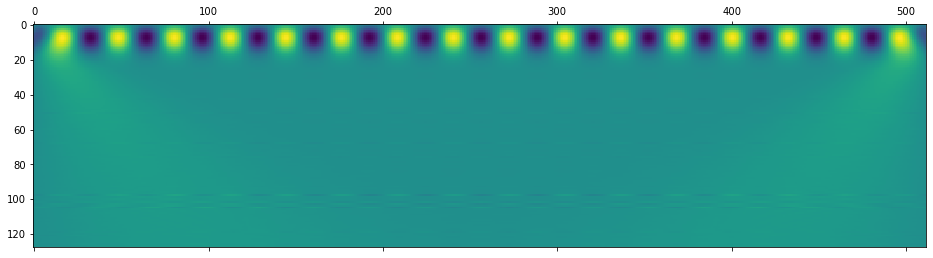

In [12]:
x = np.arange(512)
y = np.sin(2*np.pi*x/32)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(coef) # doctest: +SKIP
plt.show() # doctest: +SKIP

In [13]:
# test sur un signal trigonométrique
t = np.linspace(-1, 1, 200, endpoint=False)
t_0 = 0.2
f_0 = 10
sig_test  = np.cos(2 * np.pi * f_0 * t) + np.real(np.exp(-f_0*(t-t_0)**2)*np.exp(1j*2*np.pi*2*(t-t_0)))

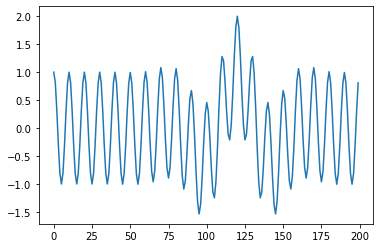

In [14]:
plt.plot(sig_test);

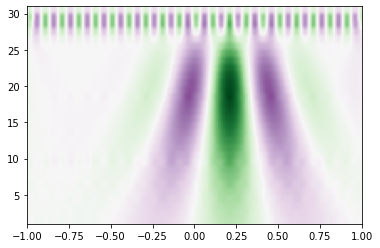

In [15]:
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(sig_test, widths, 'mexh')
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
plt.show() # doctest: +SKIP

In [16]:
# test sur une entrée du jeu de données d'entrainement
sig = X_train.iloc[1000,:]

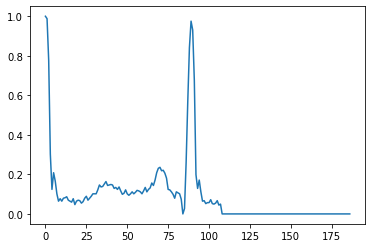

In [17]:
plt.plot(sig);

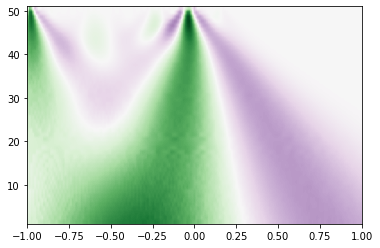

In [18]:
t = np.linspace(-1, 1, 200, endpoint=False)
#t_0 = 0.2
#f_0 = 10
#sig  = np.cos(2 * np.pi * f_0 * t) + np.real(np.exp(-f_0*(t-t_0)**2)*np.exp(1j*2*np.pi*2*(t-t_0)))

widths = np.arange(1, 51)
cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
plt.imshow(cwtmatr, extent=[-1, 1, 1, 51], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
plt.show() # doctest: +SKIP

In [19]:
def rand_by_target(signals, target) :
    # prend en entrée une signal et une valeur de cible
    # renvoie une entrée aléatoire correspondant à la cible ainsi que son indice
    m=signals.shape[1]
    selection = signals[signals.iloc[:,m-1]==target] # séléctionne toutes les entrées correspondant à la classe
    n=selection.shape[0]
    r = random.randint(0, n-1)
    #print('Ligne séléctionnée : ',r)
    return(selection.iloc[r,:-1],r)

In [20]:
def get_cwt_matr_3D(signals, scale, wave):
    # prend en entrée le jeu de données, une valeur d'échelle et un type d'ondelettes continues
    # renvoie un ensemble matrice wavelett continues correspondant à toutes les entrées
    n=signal.shape[0]
    m=signal.shape[1]
    print('(',scale,',',n,',',m,')') # affiche les dimensions de la matrice
    widths = np.arange(1,scale+1) # définie un intervalle à partir de l'échelle
    cwtmatr, freqs = pywt.cwt(signals, widths, wave)
    return (cwtmatr) # retourne uniquement la matrice 3D de toutes les entrées

In [21]:
def get_cwt_matr_2D (signal, line, scale, wave):
    # prend en entrée le jeu de données, l'entrée que l'on souhaite séléctionner une valeur d'échelle et un type d'ondelettes continues
    # renvoie une matrice de wavelett continues correspondant à l'entrée passée en param
    n=signal.shape[0]
    m=signal.shape[1]
    print('(',scale,',',n,',',m,')') # affiche les dimensions de la matrice
    widths = np.arange(1,scale+1) # définie un intervalle à partir de l'échelle
    cwtmatr, freqs = pywt.cwt(signal, widths, wave)
    return (cwtmatr[:,line,:]) # retourne uniquement la matrice correspondant à l'entrée passée en param

In [22]:
def get_cwt_matr_2D_rand (signal, scale, wave, sigClass):
    # prend en entrée le jeu de données, une valeur d'échelle, un type d'ondelettes continues et une classe de signaux
    # renvoie une matrice de wavelett continues correpondant à une entrée aléatoire du jeu
    m=signals.shape[1] # nombre de col
    selection = signals[signals.iloc[:,m-1]==sigClass] # séléctionne toutes les entrées correspondant à la classe
    n=selection.shape[0] # nombre de lignes de la selection
    r = random.randint(0, n-1) # indice de ligne aléatoire sur la selection
    widths = np.arange(1,scale+1) # définie un intervalle à partir de l'échelle
    cwtmatr, freqs = pywt.cwt(signal, widths, wave, sigClass)
    line = random.randint(0, n-1)
    return (cwtmatr[:,line,:-1]) # retourne la matrice CWT aléatoire correpondant à la classe entrée en params

In [23]:
def get_cwt_freq_2D_rand (signal, scale, wave, sigClass):
    # prend en entrée le jeu de données, une valeur d'échelle, un type d'ondelettes continues et une classe de signaux
    # renvoie une matrice de wavelett continues correpondant à une entrée aléatoire du jeu
    m=signal.shape[1] # nombre de col
    selection = signal[signal.iloc[:,m-1]==sigClass] # séléctionne toutes les entrées correspondant à la classe
    n=selection.shape[0] # nombre de lignes de la selection
    r = random.randint(0, n-1) # indice de ligne aléatoire sur la selection
    widths = np.arange(1,scale+1) # définie un intervalle à partir de l'échelle
    cwtmatr, freqs = pywt.cwt(signal, widths, wave)
    line = random.randint(0, n-1)
    return (freqs) # retourne la fréquence sur une entrée aléatoire correpondant à la classe entrée en params

In [24]:
# fonction à utilioose poure le graphique

def get_cwt (signal, scale, wave, sigClass):
    # prend en entrée le jeu de données, une valeur d'échelle, un type d'ondelettes continues et une classe de signaux
    # renvoie une matrice de wavelett continues correpondant à une entrée aléatoire du jeu
    m=signal.shape[1] # nombre de col
    selection = signal[signal.iloc[:,m-1]==sigClass] # séléctionne toutes les entrées correspondant à la classe
    n=selection.shape[0] # nombre de lignes de la selection
    r = random.randint(0, n-1) # indice de ligne aléatoire sur la selection
    widths = np.arange(1,scale+1) # définie un intervalle à partir de l'échelle
    cwtmatr, freqs = pywt.cwt(signal, widths, wave)
    line = random.randint(0, n-1)
    return (signal.iloc[line,:-1],freqs, cwtmatr[:,line,:-1]) # retourne la fréquence sur une entrée aléatoire correpondant à la classe entrée en params

In [25]:
a, b, c = get_cwt (mit_train, 3, 'mexh', 1)
#print(c)

[[ 3.92826000e-01  7.50041810e-01 -9.36899946e-02 -3.67451302e-01
  -1.02395118e-01  2.20035425e-02  1.73121351e-02  3.09716654e-03
   7.68415395e-04  1.65921080e-03  3.31269689e-04  1.04285177e-03
   5.57315241e-04 -1.44275814e-03  1.72544174e-04  3.24440401e-04
  -5.16968073e-03 -1.98534056e-03  1.53740351e-03 -3.31476053e-03
  -3.57187490e-03 -3.04025719e-03 -6.21466391e-03 -2.28001105e-03
  -5.22830050e-03 -1.01887347e-02 -7.28788806e-03 -6.69570344e-03
  -9.42720842e-03 -9.66982454e-03  1.59082039e-03  7.38544632e-03
   5.71874896e-03  1.25456882e-02  2.99883247e-02  5.39194574e-02
   6.10188519e-02  4.17039911e-02  1.64079465e-02 -8.91297425e-04
  -2.04012258e-02 -3.62406581e-02 -2.96782114e-02 -2.16898485e-02
  -1.89098371e-02 -1.20248521e-02 -3.92695470e-03 -3.50858505e-04
  -1.99216011e-03 -3.46930485e-03 -1.04610879e-03 -5.92926654e-05
  -2.08773350e-03 -1.76330220e-03  3.81732294e-04  2.25392762e-03
   1.69207374e-04 -3.29986389e-03  8.77862939e-04  5.33584576e-03
  -4.90655

In [ ]:
plt.plot(freqs)

In [ ]:
plt_ex = get_cwt_matr_2D_rand(mit_train, 2, '')

In [ ]:
cwt_matr = get_cwt_matr_2D_rand (mit_train, 3, 'mexh', 0)
plt.plot(cwt_matr);
cwt_matr.shape

In [ ]:
cwt_freq = get_cwt_freq_2D_rand(mit_train, 3, 'mexh', 0)
cwt_freq.shape

In [ ]:
plt_ex.shape

In [ ]:
cwtmatr[:,1000,:].shape

In [ ]:
cwtmatr[:,1000,:].shape

In [ ]:
plt_ex.shape

In [ ]:
len(b)

In [ ]:
plt.imshow(c, origin='upper', extent=[-1, 1, 1, len(b+1)], cmap='seismic', aspect='auto',
            vmax=abs(c).max(), vmin=-abs(c).max())  # doctest: +SKIP
plt.show() # doctest: +SKIP

In [ ]:
scale = 50
wave = 'mexh'
cwtmatr = get_cwt_matr(X_train, scale, wave)

In [ ]:
X_train.shape[0]

In [ ]:
shape(cwtmatr[:,100,:])

In [ ]:
shape(cwtmatr[:,100,186])

In [ ]:
shape(freqs)

In [ ]:
plt.plot(cwtmatr[:,1000,:]);

In [ ]:
cwtmatr[:,1000,:]

In [62]:
plt.imshow(cwtmatr[:,1000,:], origin='upper', extent=[-1, 1, 1, 51], cmap='seismic', aspect='auto',
            vmax=abs(cwtmatr[:,1000,:]).max(), vmin=-abs(cwtmatr[:,1000,:]).max())  # doctest: +SKIP
plt.show() # doctest: +SKIP

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [63]:
plt.imshow(cwtmatr[:,1000,:], origin='upper', extent=[-1, 1, 1, 51], cmap='nipy_spectral', aspect='auto',
            vmax=abs(cwtmatr[:,1000,:]).max(), vmin=-abs(cwtmatr[:,1000,:]).max())  # doctest: +SKIP
plt.show() # doctest: +SKIP

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

[0.25       0.125      0.08333333 0.0625     0.05       0.04166667
 0.03571429 0.03125   ]
[0.25       0.125      0.08333333 0.0625     0.05       0.04166667
 0.03571429 0.03125   ]
[0.25       0.125      0.08333333 0.0625     0.05       0.04166667
 0.03571429 0.03125   ]
[0.25       0.125      0.08333333 0.0625     0.05       0.04166667
 0.03571429 0.03125   ]
[0.25       0.125      0.08333333 0.0625     0.05       0.04166667
 0.03571429 0.03125   ]


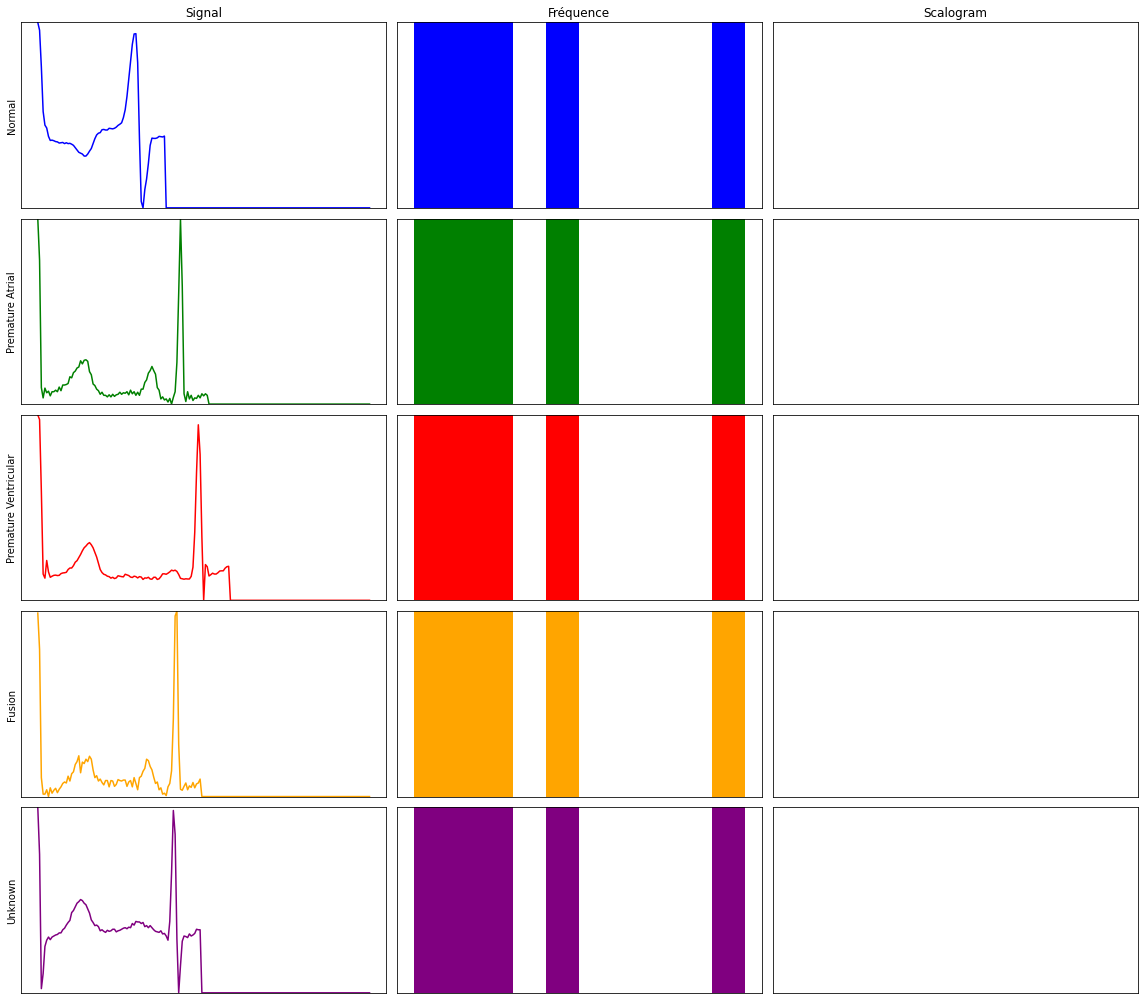

<Figure size 1800x1200 with 0 Axes>

''

<Figure size 432x288 with 0 Axes>

In [37]:
fig, axes = plt.subplots(5, 3, figsize = (16,14))

col_sig = ['blue','green','red','orange','purple']
col_scal= ['Blues','Greens','Reds','Oranges','Purples']
classLabs = ['Normal','Premature Atrial','Premature Ventricular','Fusion','Unknown']
#grTitles = ['Signal', 'Fréquence', 'Scalogram']

axes[0,0].set_title('Signal')
axes[0,1].set_title('Fréquence')
axes[0,2].set_title('Scalogram')

for i in range(0,5):
    for j in range(0,3):
        axes[i,j].tick_params(axis = "both", labelbottom = False, labelleft = False, length = 0)
        axes[i,j].set_ylim(0,1)

    scale = 8
    cw_type = 'mexh'
    
    sig, freq, matr = get_cwt (mit_train, scale, cw_type, i)
     
    axes[i,0].set_ylabel(classLabs[i])
    
    axes[i,0].plot(sig,color = col_sig[i])

    axes[i,1].hist(freq ,color = col_sig[i])
    
    axes[i,2].imshow(matr, origin='upper', extent=[-1, 1, 1, len(freq)+1], cmap =col_scal[i], aspect='auto',
            vmax=abs(matr).max(), vmin=-abs(matr).max())  # doctest: +SKIP
    #axes[i,2].show() # doctest: +SKIP

fig.tight_layout()
fig = plt.gcf()
plt.figure(dpi=300)
plt.show();
plt.savefig('mit_classe_superp.png', dpi = 300) 
;

In [89]:
sig, freq, matr = get_cwt (mit_train, scale, cw_type, 0)

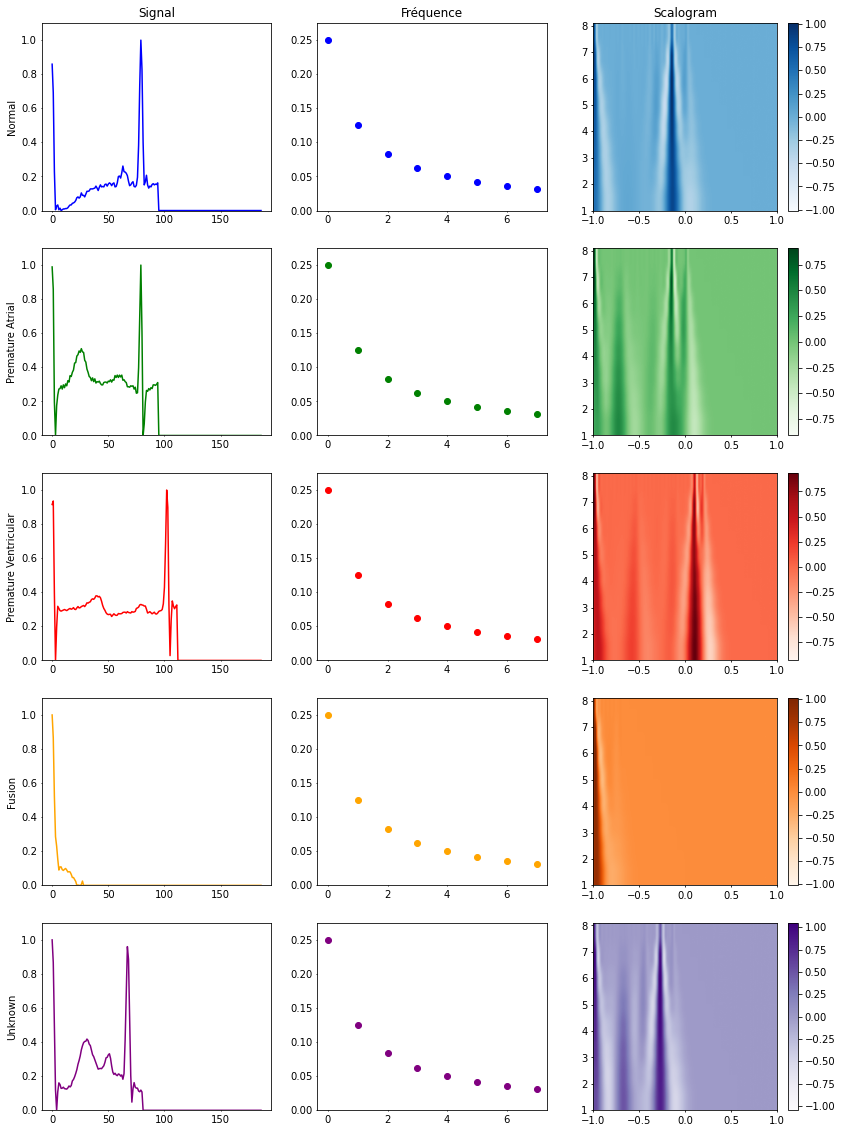

''

In [132]:
fig, axes = plt.subplots(5, 3, figsize = (14,20))

col_sig = ['blue','green','red','orange','purple']
col_scal= ['Blues','Greens','Reds','Oranges','Purples']
classLabs = ['Normal','Premature Atrial','Premature Ventricular','Fusion','Unknown']
#grTitles = ['Signal', 'Fréquence', 'Scalogram']

axes[0,0].set_title('Signal')
axes[0,1].set_title('Fréquence')
axes[0,2].set_title('Scalogram')

for i in range(0,5):
    
    scale = 8
    cw_type = 'mexh'
    sig, freq, matr = get_cwt (mit_train, scale, cw_type, i)
    
    for j in range(0,3):
       # fig = plt.figure()
       # axes[i,j] = fig.add_subplot(5, 3, j+1)
        axes[i,j].tick_params(axis = "both", which = "both", labelbottom = True, labelleft = True, length = 1)
        axes[i,j].set_ylim(0,1)

    axes[i,0].set_ylabel(classLabs[i])
    sig_Max = max(sig)
    axes[i,0].plot(sig,color = col_sig[i])
    axes[i,0].set_ylim(0,sig_Max*1.1)
    
    xFreq = range(0,len(freq))
    freqMax = max(freq)
    axes[i,1].scatter(x= xFreq, y= freqTest, color = col_sig[i])
    axes[i,1].set_ylim(0, freqMax*1.1)
   
    ax=axes[i,2]
    img = ax.imshow(matr, origin='upper', extent=[-1, 1, 1, len(freq)+0.1], cmap =col_scal[i], aspect='auto',
            vmax=abs(matr).max(), vmin=-abs(matr).max())  # doctest: +SKIP
    fig.colorbar(img, ax=ax)
    axes[i,2].tick_params(axis = 'both', labelbottom = True, labelleft = True, length = 2)
    axes[i,2].set_ylim(1,len(freq)+0.1)
    axes[i,2].set_xlim(-1,1)

    

#fig.tight_layout()
#fig.gcf()
#plt.figure(dpi=300)
#fig.show(c, axes = axes[i,j]);
#axes.show();
plt.show()
#plt.savefig('mit_classe_superp.png', dpi = 300) 
;

In [ ]:
sig, freq, matr = get_cwt (mit_train, scale, cw_type, 0)

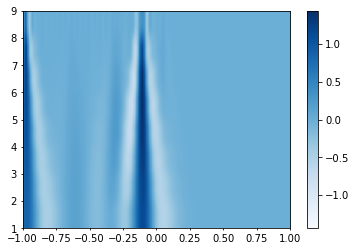

In [113]:

plt.imshow(matr, origin='upper', extent=[-1, 1, 1, len(freq)+1], cmap =col_scal[i], aspect='auto',
            vmax=abs(matr).max(), vmin=-abs(matr).max())  # doctest: +SKIP

plt.tick_params(axis = 'both', labelbottom = True, labelleft = True, length = 2)
plt.colorbar()
#plt.set_ylim(-1,1)
#plt.set_xlim(-1,1)
plt.show() # doctest: +SKIP

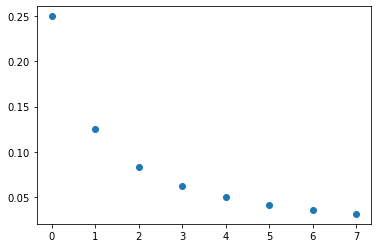

In [48]:
freqTest = [0.25, 0.125, 0.08333333, 0.0625, 0.05, 0.04166667, 0.03571429, 0.03125]
xTest = range(0,len(freqTest))
plt.scatter(x= xTest, y= freqTest)

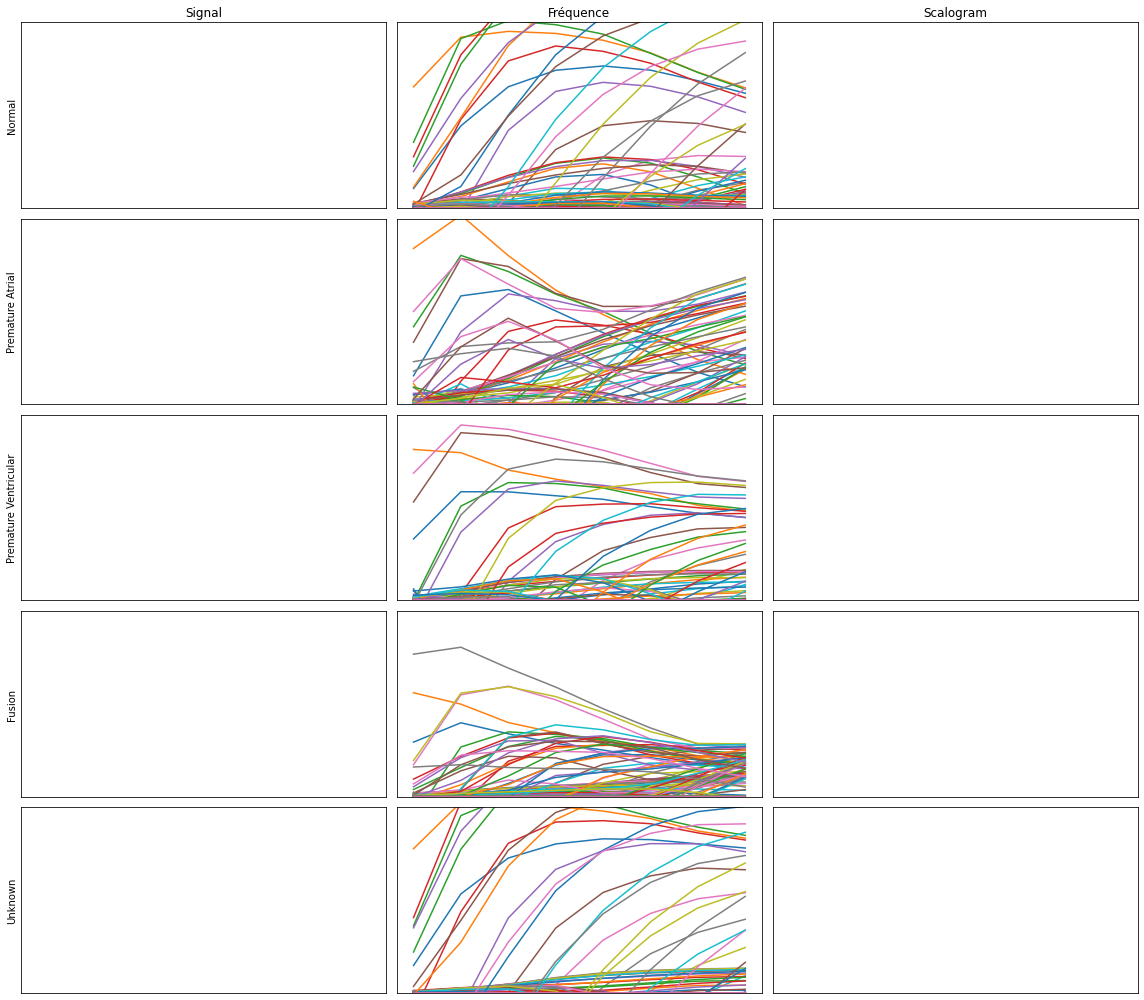

<Figure size 1800x1200 with 0 Axes>

''

<Figure size 432x288 with 0 Axes>

In [33]:
fig, axes = plt.subplots(5, 3, figsize = (16,14))

col_sig = ['blue','green','red','orange','purple']
col_scal= ['Blues','Greens','Reds','Oranges','Purples']
classLabs = ['Normal','Premature Atrial','Premature Ventricular','Fusion','Unknown']
#grTitles = ['Signal', 'Fréquence', 'Scalogram']

axes[0,0].set_title('Signal')
axes[0,1].set_title('Matrice')
axes[0,2].set_title('Scalogram')

for i in range(0,5):
    for j in range(0,3):
        axes[i,j].tick_params(axis = "both", labelbottom = False, labelleft = False, length = 0)
        axes[i,j].set_ylim(0,1)

    scale = 8
    cw_type = 'mexh'
    
    sig, freq, matr = get_cwt (mit_train, scale, cw_type, i)
     
    axes[i,0].set_ylabel(classLabs[i])
    
    #axes[i,0].plot(sig,color = col_sig[i])

    axes[i,1].plot(matr)
    
    axes[i,2].imshow(matr, origin='upper', extent=[-1, 1, 1, len(freq)+1], cmap =col_scal[i], aspect='auto',
            vmax=abs(matr).max(), vmin=-abs(matr).max())  # doctest: +SKIP
    #axes[i,2].show() # doctest: +SKIP

fig.tight_layout()
fig = plt.gcf()
plt.figure(dpi=300)
plt.show();
plt.savefig('mit_classe_superp.png', dpi = 300) 
;